# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [140]:
#pip install fuzzywuzzy

In [141]:
import catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split

### 데이터 셋 읽어오기

In [142]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [143]:
df_train.head() # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.0,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.0,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.0,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.0,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True


In [144]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         58317 non-null  object 
 2   business_unit            59299 non-null  object 
 3   com_reg_ver_win_rate     14568 non-null  float64
 4   customer_idx             59299 non-null  int64  
 5   customer_type            15338 non-null  object 
 6   enterprise               59299 non-null  object 
 7   historical_existing_cnt  13756 non-null  float64
 8   id_strategic_ver         3444 non-null   float64
 9   it_strategic_ver         1121 non-null   float64
 10  idit_strategic_ver       4565 non-null   float64
 11  customer_job             40566 non-null  object 
 12  lead_desc_length         59299 non-null  int64  
 13  inquiry_type             58358 non-null  object 
 14  product_category      

In [145]:
missing_values = df_train.isnull().sum()
print("결측치 확인:\n", missing_values)

결측치 확인:
 bant_submit                    0
customer_country             982
business_unit                  0
com_reg_ver_win_rate       44731
customer_idx                   0
customer_type              43961
enterprise                     0
historical_existing_cnt    45543
id_strategic_ver           55855
it_strategic_ver           58178
idit_strategic_ver         54734
customer_job               18733
lead_desc_length               0
inquiry_type                 941
product_category           19374
product_subcategory        50064
product_modelname          50070
customer_country.1           982
customer_position              0
response_corporate             0
expected_timeline          30863
ver_cus                        0
ver_pro                        0
ver_win_rate_x             40882
ver_win_ratio_per_bu       43995
business_area              40882
business_subarea           53773
lead_owner                     0
is_converted                   0
dtype: int64


In [146]:
unique_values = df_train['product_category'].unique()
print(unique_values)

['multi-split' 'single-split' 'vrf' 'chiller' 'etc.' 'rac'
 'teto ou cassete inverter' nan 'software solution' 'all lg vrf systems'
 'ventilation' 'a thermodynamic water heater'
 'residential air conditioner' 'outros' 'heating' 'multi v5 vrf'
 'split tunggal' 'multi inverter' 'חימום' 'standard signage'
 'high brightness signage' 'interactive signage' 'video wall signage'
 'led signage' 'hotel tv' 'signage care solution' 'oled signage' 'idb'
 'video wall' 'one:quick series' 'commercial tv' 'lg one:quick'
 'special signage' 'other' 'accessories' 'commercial display'
 'interactive digital board' 'standard' 'uhd signage' 'smart tv signage'
 'lg one:quick series' 'pro:centric' 'ur640' 'ur640s' 'webos'
 'signage care solutions' 'aio | one quick' 'high brightness'
 'hospital tv' 'digital signage' 'monitor' 'pc' 'laptop' 'projector'
 'cloud device' 'medical display' 'washing machine,dryer' 'solar,chiller'
 'system ac,rac' 'monitor signage,commercial tv,monior/monitor tv'
 'monitor signage,moni

In [147]:
unique_values = df_test['product_category'].unique()
print(unique_values)

[nan 'hospital tv' 'led signage' 'cloud device' 'standard signage'
 'interactive signage' 'multi-split' 'video wall signage' 'vrf' 'monitor'
 'etc.' 'heating' 'ventilation' 'control' 'single-split'
 'high brightness signage' 'chiller' 'oled signage' 'special signage'
 'hotel tv' 'projector' 'medical display' 'signage care solution' 'ess'
 'laptop' 'interactive digital board' 'pro:centric' 'software solution'
 'others' 'one:quick series' 'webos' 'notebook' 'accessories' 'other']


In [148]:
unique_values = df_train['product_subcategory'].unique()
print(unique_values)

[nan 'New High Haze UHD Standard Signage' 'Window Facing Display'
 'LG CreateBoard' 'UR640S Series' 'TR3DJ Series' 'webOS UHD Signage'
 'TN3F Series' 'SM3G Series'
 '55" 500 nits FHD 0.44mm Even Bezel Video Wall' 'UH5F-H Series'
 'Interactive Digital Board' 'Createboard' 'UHD TV Signage'
 '55" 700 nits FHD 0.44mm Even Bezel Video Wall' 'LT340C Series'
 'Ultra Narrow Bezel Video Wall' 'Fine-pitch Essential Series'
 'UT640S Series' 'Outdoor Display' 'TR3BG Series' 'SuperSign CMS'
 'Touch Open Frame' 'LT341H Series' 'Total Care Solution'
 'Ultra Slim Series' 'LG MAGNIT' 'Wallpaper OLED Signage'
 'Indoor Versatile Series' 'VL5F Series' 'Transparent OLED' 'TA3E Series'
 'OneQuick Flex' 'UL3J' 'Compact Series' 'TR3BF Series' '4K UHD Smart TV'
 'Transparent LED Film' 'One:Quick Flex' 'One:Quick Works for Zoom Rooms'
 'Transparent OLED Signage' 'LG Simple Editor' 'VH7B Series'
 'Transparent OLED Touch Signage' 'Full HD Standard Signage' 'VL7F Series'
 '49" 500 nits FHD Slim Bezel Video Wall' '

In [149]:
unique_values = df_train['product_modelname'].unique()
print(unique_values)

[nan '98UH5J-H' '75XS4G' '86TR3DK' '43UR640S' '86TR3DJ' '75UL3J-B'
 '22SM3G-B' '55VSM5J' '55UH5F-H' '75TC3D' '86TR3PJ' '65UR640S (ASIA)'
 '55VSH7J' '43LT340C (EU)' '55LV77D' 'LAS009-F' '55UT640S (ASIA)'
 '98TR3PJ' '75TR3DJ' '55TR3BG' '65TR3DK' '43TNF5J' '43LT341H (EU)'
 '55UL3J-B' '55UR640S (EU/CIS)' '55UR640S' 'LSAB009' 'LSCA039' '55VL5F-A'
 '55EW5G' '43TA3E' '43HT3WJ' '43UL3J' '86TR3E' '65TR3BF-B'
 '65UQ801C (INDIA)' '32LT340C' 'LAT140' 'LSCB018' '55CT5WJ-ZJ' '55EW5PG-S'
 '55VH7B' '86UH5J-H' '55EW5TK-A' '32SM5J-B' '55VL7F-A' '49VL5G-M'
 '55CT5WJ' '65TR3DJ' '32SM5J' '65EV5E' '55VL5F' '55TC3CD' '110UM5J'
 '49XE4F-M' '75UH5J-H' '55EW5G-V' '49VL5G' '49VL5F-A' '49VL5PJ' '55LV75D'
 '55XS4J-B' '55VM5J-H' 'SC-00DA' '85TR3BF' '55VX1D' '49LT560H (NA)'
 'LG SuperSign CMS' '55UH5F-B' '55LV35A' '55EF5G-P' '49LT340C' '55SVH7F'
 '32TA3E' '75UR640S (NA)' '43UH5F-B' '55EF5G-L' 'LSAA012' '55VH7E'
 '55TC3D' '55UL3J' '55VL7F' '43LT340C' '55EW5TF' '55EW5F EW5G' '55UT640S'
 '55UH5E' '55EW5F-A' '49VM5E-A' 

In [150]:
unique_values = df_train['response_corporate'].unique()
print(unique_values)

['LGEPH' 'LGEIL' 'LGEAF' 'LGESJ' 'LGESL' 'LGESP' 'LGEGF' 'LGESA' 'LGEUS'
 'LGECB' 'LGEMS' 'LGEEG' 'LGEEF' 'LGEAP' 'LGEIN' 'LGEUK' 'LGEKR' 'LGEPS'
 'LGECI' 'LGECL' 'LGETK' 'LGELF' 'LGEPT' 'LGEPR' 'LGEDG' 'LGERO' 'LGEMK'
 'LGEPL' 'LGECZ' 'LGEES' 'LGEAR' 'LGEHK' 'LGEML' 'LGEJP' 'LGEHS' 'LGEAS'
 'LGEYK' 'LGEIS' 'LGEBN' 'LGEFS' 'LGESW' 'LGEMC' 'LGEAG' 'LGEEB' 'LGETH'
 'LGEVH' 'LGECH' 'LGELA' 'LGETT' 'LGERA' 'LGEUR' 'LGEIR' 'LGEBT']


In [151]:
unique_values = df_train['customer_type'].unique()
print(unique_values)

['End-Customer' 'Specifier/ Influencer' 'Service Partner'
 'Channel Partner' nan 'Corporate' 'End Customer' 'Specifier / Influencer'
 'Solution Eco-Partner' 'Distributor' 'Other' 'System Integrator'
 'Consultant' 'Installer' 'Homeowner' 'Others' 'Technician'
 'Installer/Contractor' 'Engineer' 'Manager / Director' 'Developer' 'Etc.'
 'Architect/Consultant' 'End-user' 'HVAC Engineer' 'Reseller'
 'Software/Solution Provider' 'Software / Solution Provider'
 'Dealer/Distributor' 'Technical Assistant' 'Commercial end-user'
 'Interior Designer' 'Home Owner' 'Administrator']


In [152]:
unique_values = df_train['business_area'].unique()
print(unique_values)

['corporate / office' nan 'education' 'hotel & accommodation'
 'hospital & health care' 'special purpose' 'residential (home)'
 'government department' 'retail' 'factory'
 'power plant / renewable energy' 'transportation' 'public facility']


In [193]:
unique_values = df_train['product_category'].unique()
print(unique_values)

['interactivedigitalboard' 'etc' 'videowallsignage' 0 'multisplit'
 'ledsignage' 'ventilation' 'interactivesignage' 'rac' 'hoteltv'
 'lgonequickseries' 'projector' 'vrf' 'commercialdisplay' 'oledsignage'
 'chiller' 'onequickseries' 'singlesplit' 'medicaldisplay'
 'standardsignage' '43us660h0sdawz' 'vrfmultisplitsinglesplitchiller'
 'tetooucasseteinverter' 'highbrightness' 'pc' 'outros'
 'athermodynamicwaterheater' 'heating' 'accessories' 'tvaudiovideo'
 'highbrightnesssignage' 'ur640s' 'procentric' 'multivwater5'
 'commercialtv' 'specialsignage' 'arcondicionadoresidencial' 'hospitaltv'
 'monitor' 'ogrzewaniepompyciepa' 'robots' 'collaborationdisplays'
 'computermonitors' 'medicalmonitors' 'multiinverter' 'chilleraircare'
 'commercialtvtv' 'emsaudiovideo' '55uq801c0sbbwz' 'ultrastretchseries'
 'onorseveralreversibleac' 'istma' 'signagecaresolution' 'smarttvsignage'
 'clouddevice' 'oled' 'salesinquiry' 'vrfmultisplit' 'softwaresolution'
 'virtualproduction' 'videowall' 'tvsignage' 'contr

In [153]:
#열 지우기
columns_to_remove = [ 'idit_strategic_ver','customer_country.1']

df_train = df_train.drop(columns=columns_to_remove)
df_test = df_test.drop(columns=columns_to_remove)

In [154]:
#product_category값 번역

from googletrans import Translator

# 'product_category' 열이 존재할 때만 번역 함수를 적용
if 'product_category' in df_train.columns:
    # 번역 함수
    def translate_to_english(text):
        try:
            translator = Translator()
            translation = translator.translate(text, dest='en').text
            return translation
        except Exception as e:
            print(f"Error during translation: {e}")
            return text
    # 'product_category' 열 값만 번역
    df_train['product_category'] = translate_to_english(df_train[['product_category']])['product_category']
else :
    df_train['product_category'] = df_train['product_category'].fillna(0)

Error during translation: Object of type DataFrame is not JSON serializable


In [155]:
# 'product_category' 열이 존재할 때만 번역 함수를 적용
if 'product_category' in df_test.columns:
    # 번역 함수
    def translate_to_english(text):
        try:
            translator = Translator()
            translation = translator.translate(text, dest='en').text
            return translation
        except Exception as e:
            print(f"Error during translation: {e}")
            return text
    # 'product_category' 열 값만 번역
    df_test['product_category'] = translate_to_english(df_test[['product_category']])['product_category']
else :
    df_test['product_category'] = df_test['product_category'].fillna(0)  

Error during translation: Object of type DataFrame is not JSON serializable


In [156]:
df_train['product_category']

0                 multi-split
1                 multi-split
2                single-split
3                         vrf
4                 multi-split
                 ...         
59294                     vrf
59295                    etc.
59296            single-split
59297                    etc.
59298    monior/monitor tv,tv
Name: product_category, Length: 59299, dtype: object

In [157]:
unique_values = df_train['inquiry_type'].unique()
print(unique_values)

['Quotation or purchase consultation' 'Product Information'
 'Quotation or Purchase Consultation' 'Other'
 'Usage or technical consultation' 'Trainings' 'Services' 'Sales Inquiry'
 'Etc.' 'Technical Support' 'Usage or Technical Consultation'
 'Technical Consultation' 'Request for Partnership' nan 'sales'
 'technical' 'usage or technical consultation'
 'usage_or_technical_consultation' 'other'
 'quotation_or_purchase_consultation' 'other_' 'Request a Demo'
 'Request for Distributorship' 'Request for quotation or purchase'
 'Request for technical consulting' '(Select ID_Needs)' 'One Quick:Flex'
 'AIO' 'Needs' 'Purchase' 'technical_consultation' 'Customer Suggestions'
 'Event Inquiry' 'Others' 'OEM/ODM Request' 'Hospital TV' 'others'
 'i want to know the details about it' 'EDUCATIONAL EQUIPMENTS'
 'Digital platform' 'TV interactive' 'teach' 'Display Textbook and photos'
 'High inch 86 / 98 or 110' 'quotation_' 'Purchase or Quotation'
 'display product' 'first Info and pricing' 'Sales inqu

In [158]:
#inquiry_type 결측치 값 others로 저장
df_train['inquiry_type'] = df_train['inquiry_type'].fillna('others')
df_test['inquiry_type'] = df_test['inquiry_type'].fillna('others')

In [159]:
# 'inquiry_type' 열의 값에서 언더스코어와 띄어쓰기 없애기
df_train['inquiry_type'] = df_train['inquiry_type'].str.replace('_', '').str.replace(' ', '')
df_test['inquiry_type'] = df_test['inquiry_type'].str.replace('_', '').str.replace(' ', '')
# 'inquiry_type' 열의 값들을 소문자로 변환
df_train['inquiry_type'] = df_train['inquiry_type'].str.lower()
df_test['inquiry_type'] = df_test['inquiry_type'].str.lower()

In [160]:
df_train['inquiry_type']

0        quotationorpurchaseconsultation
1        quotationorpurchaseconsultation
2                     productinformation
3        quotationorpurchaseconsultation
4        quotationorpurchaseconsultation
                      ...               
59294                 productinformation
59295                             others
59296                             others
59297    quotationorpurchaseconsultation
59298      requestforquotationorpurchase
Name: inquiry_type, Length: 59299, dtype: object

In [161]:
df_train['customer_country'] = df_train['response_corporate']+df_train['lead_owner'].astype(str)
df_test['customer_country'] = df_test['response_corporate']+df_test['lead_owner'].astype(str)

In [162]:
unique_values = df_train['customer_country'].unique()
print(unique_values)

['LGEPH0' 'LGEPH1' 'LGEIL2' ... 'LGEAF964' 'LGESP1111' 'LGECB1114']


In [163]:
#customer_type 결측치 처리
df_train['customer_type'] = df_train['customer_type'].fillna('End-Customer')
df_test['customer_type'] = df_test['customer_type'].fillna('End-Customer')

In [164]:
# 'customer_type' 열의 값에서 언더스코어와 띄어쓰기 없애기
df_train['customer_type'] = df_train['customer_type'].str.replace('_', '').str.replace(' ', '').str.replace('-', '')
df_test['customer_type'] = df_test['customer_type'].str.replace('_', '').str.replace(' ', '').str.replace('-', '')
# 'customer_type' 열의 값들을 소문자로 변환
df_train['customer_type'] = df_train['customer_type'].str.lower()
df_test['customer_type'] = df_test['customer_type'].str.lower()

In [165]:
df_train['customer_type']

0                 endcustomer
1                 endcustomer
2                 endcustomer
3                 endcustomer
4        specifier/influencer
                 ...         
59294             endcustomer
59295    specifier/influencer
59296    specifier/influencer
59297             endcustomer
59298             endcustomer
Name: customer_type, Length: 59299, dtype: object

In [166]:
unique_values = df_train['business_subarea'].unique()
print(unique_values)

['Engineering' 'Advertising' 'Construction' 'IT/Software' nan
 'Manufacturing' 'Energy' 'Developer/Property' 'Entertainment'
 'Agriculture' 'Pharmaceutical' 'Others' 'Banking' 'Consulting'
 'Healthcare' 'Finance' 'Broadcasting & Media' 'Distribution Center'
 'Law Firm' 'Logistics' 'Telecommunication' 'Aerospace' 'Network/Cabling'
 'Insurance' 'Institute & Academy' 'Hotel' 'K12 Kindergarten & Schools'
 'Hospital' 'Mixed-use (Multi Complex)'
 'Telecom Base Station / Data, Call' 'Botanical Garden / Green House'
 'Higher Education (College & University)' 'Clinic' 'General Hospital'
 'Fitness' 'LTC(Long-Term Care)' 'Villa / Single-Family Home' 'Apartment'
 'Townhouse' 'Officetel' 'General Government Office' 'Military'
 'Police / Fire station' 'Welfare Facilities' 'Other Stores'
 'Luxury(Watch/Jewelry Shop)' 'Electronics & Telco' 'Sports Entertainment'
 'CVS (Convenience Store)' 'Car Dealership' 'Fashion'
 'QSR(Quick Service Restaurant)' 'Hyper Market & Grocery' 'Shopping Mall'
 'Cosmetics' 

In [169]:
df_train['business_area']

2722                    NaN
24371    residential (home)
34294                   NaN
49534                   NaN
49714                   NaN
                ...        
50181        transportation
50309        transportation
51261        transportation
51342        transportation
51995        transportation
Name: business_area, Length: 59299, dtype: object

In [170]:
df_test.head(10)

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,LGESP278,ID,0.073248,47466,endcustomer,Enterprise,53.0,NaN,...,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,1
1,9738,0.25,LGEUS437,IT,NaN,5405,endcustomer,SMB,NaN,NaN,...,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,1
2,8491,1.00,LGEGF874,ID,NaN,13597,specifier/influencer,SMB,NaN,NaN,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,0
3,19895,0.50,LGEUS194,ID,0.118644,17204,endcustomer,Enterprise,NaN,NaN,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,17204,194,0
4,10465,1.00,LGESP167,ID,0.074949,2329,endcustomer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,1
5,17528,0.00,LGEDG429,IT,NaN,22534,endcustomer,SMB,NaN,NaN,...,LGEDG,NaN,0,0,NaN,NaN,NaN,22534,429,0
6,2853,1.00,LGEEG234,ID,NaN,32761,endcustomer,Enterprise,NaN,NaN,...,LGEEG,6 months ~ 9 months,0,0,NaN,NaN,NaN,32761,234,0
7,3061,1.00,LGEFS577,ID,NaN,46010,servicepartner,Enterprise,NaN,NaN,...,LGEFS,3 months ~ 6 months,0,0,NaN,NaN,NaN,46010,577,0
8,2909,0.75,LGEUS310,ID,NaN,2452,endcustomer,Enterprise,0.0,NaN,...,LGEUS,3 months ~ 6 months,0,0,NaN,NaN,NaN,2452,310,1
9,9577,0.25,LGEUS353,ID,0.833333,26303,endcustomer,Enterprise,32.0,NaN,...,LGEUS,NaN,0,0,0.000013,0.053571,transportation,Others,353,1


In [171]:
df_train=df_train.fillna(0)
df_test=df_test.fillna(0)

In [172]:
df_test.head(10)

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,LGESP278,ID,0.073248,47466,endcustomer,Enterprise,53.0,0.0,...,LGESP,0,1,0,0.001183,0.049840,retail,Electronics & Telco,278,1
1,9738,0.25,LGEUS437,IT,0.000000,5405,endcustomer,SMB,0.0,0.0,...,LGEUS,0,0,0,0.000013,0.000000,transportation,Others,437,1
2,8491,1.00,LGEGF874,ID,0.000000,13597,specifier/influencer,SMB,0.0,0.0,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,0
3,19895,0.50,LGEUS194,ID,0.118644,17204,endcustomer,Enterprise,0.0,0.0,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,17204,194,0
4,10465,1.00,LGESP167,ID,0.074949,2329,endcustomer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,1
5,17528,0.00,LGEDG429,IT,0.000000,22534,endcustomer,SMB,0.0,0.0,...,LGEDG,0,0,0,0.000000,0.000000,0,22534,429,0
6,2853,1.00,LGEEG234,ID,0.000000,32761,endcustomer,Enterprise,0.0,0.0,...,LGEEG,6 months ~ 9 months,0,0,0.000000,0.000000,0,32761,234,0
7,3061,1.00,LGEFS577,ID,0.000000,46010,servicepartner,Enterprise,0.0,0.0,...,LGEFS,3 months ~ 6 months,0,0,0.000000,0.000000,0,46010,577,0
8,2909,0.75,LGEUS310,ID,0.000000,2452,endcustomer,Enterprise,0.0,0.0,...,LGEUS,3 months ~ 6 months,0,0,0.000000,0.000000,0,2452,310,1
9,9577,0.25,LGEUS353,ID,0.833333,26303,endcustomer,Enterprise,32.0,0.0,...,LGEUS,0,0,0,0.000013,0.053571,transportation,Others,353,1


In [173]:
df_train.head(10)
df_test.head(10)

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,LGESP278,ID,0.073248,47466,endcustomer,Enterprise,53.0,0.0,...,LGESP,0,1,0,0.001183,0.049840,retail,Electronics & Telco,278,1
1,9738,0.25,LGEUS437,IT,0.000000,5405,endcustomer,SMB,0.0,0.0,...,LGEUS,0,0,0,0.000013,0.000000,transportation,Others,437,1
2,8491,1.00,LGEGF874,ID,0.000000,13597,specifier/influencer,SMB,0.0,0.0,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,0
3,19895,0.50,LGEUS194,ID,0.118644,17204,endcustomer,Enterprise,0.0,0.0,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,17204,194,0
4,10465,1.00,LGESP167,ID,0.074949,2329,endcustomer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,1
5,17528,0.00,LGEDG429,IT,0.000000,22534,endcustomer,SMB,0.0,0.0,...,LGEDG,0,0,0,0.000000,0.000000,0,22534,429,0
6,2853,1.00,LGEEG234,ID,0.000000,32761,endcustomer,Enterprise,0.0,0.0,...,LGEEG,6 months ~ 9 months,0,0,0.000000,0.000000,0,32761,234,0
7,3061,1.00,LGEFS577,ID,0.000000,46010,servicepartner,Enterprise,0.0,0.0,...,LGEFS,3 months ~ 6 months,0,0,0.000000,0.000000,0,46010,577,0
8,2909,0.75,LGEUS310,ID,0.000000,2452,endcustomer,Enterprise,0.0,0.0,...,LGEUS,3 months ~ 6 months,0,0,0.000000,0.000000,0,2452,310,1
9,9577,0.25,LGEUS353,ID,0.833333,26303,endcustomer,Enterprise,32.0,0.0,...,LGEUS,0,0,0,0.000013,0.053571,transportation,Others,353,1


In [174]:
import re

#데이터 소문자화, 띄어쓰기, 특수문자 제거
def preprocess_feature(feature):
  if isinstance(feature, str):  # 문자열인 경우에만 전처리 수행
    # 소문자로 변환
    feature = feature.lower()
    # 특수문자 제거
    feature = re.sub(r'[^a-zA-Z0-9]', '', feature)
    # 띄어쓰기 제거
    feature = feature.replace(" ", "")
  return feature

In [175]:
#데이터 소문자화, 띄어쓰기, 특수문자 제거
df_train['customer_country']=df_train['customer_country'].apply(preprocess_feature)
df_train['customer_type']=df_train['customer_type'].apply(preprocess_feature)
df_train['enterprise']=df_train['enterprise'].apply(preprocess_feature)
df_train['customer_job']=df_train['customer_job'].apply(preprocess_feature)
df_train['inquiry_type']=df_train['inquiry_type'].apply(preprocess_feature)
df_train['product_category']=df_train['product_category'].apply(preprocess_feature)
df_train['customer_position']=df_train['customer_position'].apply(preprocess_feature)
df_train['response_corporate']=df_train['response_corporate'].apply(preprocess_feature)
df_train['expected_timeline']=df_train['expected_timeline'].apply(preprocess_feature)
df_train['business_area']=df_train['business_area'].apply(preprocess_feature)
df_train['business_subarea']=df_train['business_subarea'].apply(preprocess_feature)
#데이터 소문자화, 띄어

In [176]:
#데이터 소문자화, 띄어쓰기, 특수문자 제거
df_test['customer_country']=df_test['customer_country'].apply(preprocess_feature)
df_test['customer_type']=df_test['customer_type'].apply(preprocess_feature)
df_test['enterprise']=df_test['enterprise'].apply(preprocess_feature)
df_test['customer_job']=df_test['customer_job'].apply(preprocess_feature)
df_test['inquiry_type']=df_test['inquiry_type'].apply(preprocess_feature)
df_test['product_category']=df_test['product_category'].apply(preprocess_feature)
df_test['customer_position']=df_test['customer_position'].apply(preprocess_feature)
df_test['response_corporate']=df_test['response_corporate'].apply(preprocess_feature)
df_test['expected_timeline']=df_test['expected_timeline'].apply(preprocess_feature)
df_test['business_area']=df_test['business_area'].apply(preprocess_feature)
df_test['business_subarea']=df_test['business_subarea'].apply(preprocess_feature)

In [177]:
#데이터 자료형 변환
df_train['bant_submit'] = df_train['bant_submit'].astype('str')
df_train['business_unit'] = df_train['business_unit'].astype('str')
df_train['customer_country'] = df_train['customer_country'].astype('category')
df_train['com_reg_ver_win_rate'] = df_train['com_reg_ver_win_rate'].astype('str')
df_train['customer_idx'] = df_train['customer_idx'].astype('str')
df_train['historical_existing_cnt'] = df_train['historical_existing_cnt'].astype('str')
df_train['id_strategic_ver'] = df_train['id_strategic_ver'].astype('str')
df_train['it_strategic_ver'] = df_train['it_strategic_ver'].astype('str')
df_train['lead_desc_length'] = df_train['lead_desc_length'].astype('category')
df_train['ver_cus'] = df_train['ver_cus'].astype('str')
df_train['ver_pro'] = df_train['ver_pro'].astype('str')
df_train['ver_win_rate_x'] = df_train['ver_win_rate_x'].astype('str')
df_train['ver_win_ratio_per_bu'] = df_train['ver_win_ratio_per_bu'].astype('str')
df_train['lead_owner'] = df_train['lead_owner'].astype('str')
df_train['is_converted'] = df_train['is_converted'].astype('int')

In [178]:
#데이터 자료형 변환
df_test['bant_submit'] = df_test['bant_submit'].astype('str')
df_test['business_unit'] = df_test['business_unit'].astype('str')
df_test['customer_country'] = df_test['customer_country'].astype('category')
df_test['com_reg_ver_win_rate'] = df_test['com_reg_ver_win_rate'].astype('str')
df_test['customer_idx'] = df_test['customer_idx'].astype('str')
df_test['historical_existing_cnt'] = df_test['historical_existing_cnt'].astype('str')
df_test['id_strategic_ver'] = df_test['id_strategic_ver'].astype('str')
df_test['it_strategic_ver'] = df_test['it_strategic_ver'].astype('str')
df_test['lead_desc_length'] = df_test['lead_desc_length'].astype('category')
df_test['ver_cus'] = df_test['ver_cus'].astype('str')
df_test['ver_pro'] = df_test['ver_pro'].astype('str')
df_test['ver_win_rate_x'] = df_test['ver_win_rate_x'].astype('str')
df_test['ver_win_ratio_per_bu'] = df_test['ver_win_ratio_per_bu'].astype('str')
df_test['lead_owner'] = df_test['lead_owner'].astype('str')
df_test['is_converted'] = df_test['is_converted'].astype('int')

In [179]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59299 entries, 2722 to 51995
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   bant_submit              59299 non-null  object  
 1   customer_country         59299 non-null  category
 2   business_unit            59299 non-null  object  
 3   com_reg_ver_win_rate     59299 non-null  object  
 4   customer_idx             59299 non-null  object  
 5   customer_type            59299 non-null  object  
 6   enterprise               59299 non-null  object  
 7   historical_existing_cnt  59299 non-null  object  
 8   id_strategic_ver         59299 non-null  object  
 9   it_strategic_ver         59299 non-null  object  
 10  customer_job             59299 non-null  object  
 11  lead_desc_length         59299 non-null  category
 12  inquiry_type             59299 non-null  object  
 13  product_category         59299 non-null  object  
 14  product_

In [180]:
# country 별로 is_converted가 True인 개수를 확인합니다.
converted_by_country = df_train[df_train['is_converted'] == True].groupby('customer_country', observed=False).size()

# 개수가 큰 순서대로 정렬합니다.
converted_by_country = converted_by_country.sort_values(ascending=False)

# 결과 출력
print(converted_by_country)

customer_country
lgeus437     135
lgesp487     117
lgeus831     104
lgesp480      98
lgeus375      88
            ... 
lgeis1031      0
lgeis1038      0
lgeis1042      0
lgeis251       0
lgeyk861       0
Length: 1033, dtype: int64


## 2. 데이터 전처리

### 레이블 인코딩

다시 학습 데이터와 제출 데이터를 분리합니다.

### 2-2. 학습, 검증 데이터 분리

In [181]:
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.2,
    shuffle=True,
    random_state=400,
)
num_true_train = y_train.sum()
num_true_val = y_val.sum()

print("y_train에서 True인 개수:", num_true_train)
print("y_val에서 True인 개수:", num_true_val)

y_train에서 True인 개수: 3892
y_val에서 True인 개수: 958


In [182]:
missing_values = x_train.isnull().sum()
print("결측치 확인:\n", missing_values)

결측치 확인:
 bant_submit                0
customer_country           0
business_unit              0
com_reg_ver_win_rate       0
customer_idx               0
customer_type              0
enterprise                 0
historical_existing_cnt    0
id_strategic_ver           0
it_strategic_ver           0
customer_job               0
lead_desc_length           0
inquiry_type               0
product_category           0
product_subcategory        0
product_modelname          0
customer_position          0
response_corporate         0
expected_timeline          0
ver_cus                    0
ver_pro                    0
ver_win_rate_x             0
ver_win_ratio_per_bu       0
business_area              0
business_subarea           0
lead_owner                 0
dtype: int64


## 3. 모델 학습

### 모델 정의 

In [183]:
from sklearn.utils.class_weight import compute_class_weight

# 클래스 라벨의 고유값 추출
classes = np.unique(y_train)

# 클래스 가중치 계산
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# 클래스 라벨과 가중치를 매핑하여 dict 생성
class_weights = dict(zip(classes, weights))

In [184]:
from catboost import CatBoostClassifier

# CatBoost 모델 정의
model = CatBoostClassifier(  class_weights=class_weights,
                            cat_features=['business_unit','customer_type','enterprise','customer_job','lead_desc_length'
                                         ,'inquiry_type','product_category','product_subcategory','product_modelname','customer_position'
                                         ,'response_corporate','expected_timeline','business_area','business_subarea'
                                         ,'customer_country'])

In [185]:
model.fit(x_train, y_train, verbose=100)

Learning rate set to 0.053536
0:	learn: 0.6257995	total: 107ms	remaining: 1m 46s
100:	learn: 0.1575510	total: 5.99s	remaining: 53.3s
200:	learn: 0.1373445	total: 11.9s	remaining: 47.1s
300:	learn: 0.1252091	total: 17.4s	remaining: 40.5s
400:	learn: 0.1154303	total: 23.4s	remaining: 35s
500:	learn: 0.1070486	total: 29.4s	remaining: 29.3s
600:	learn: 0.1003856	total: 35.4s	remaining: 23.5s
700:	learn: 0.0944062	total: 41.3s	remaining: 17.6s
800:	learn: 0.0889617	total: 47.2s	remaining: 11.7s
900:	learn: 0.0834895	total: 53.2s	remaining: 5.84s
999:	learn: 0.0795479	total: 59.1s	remaining: 0us


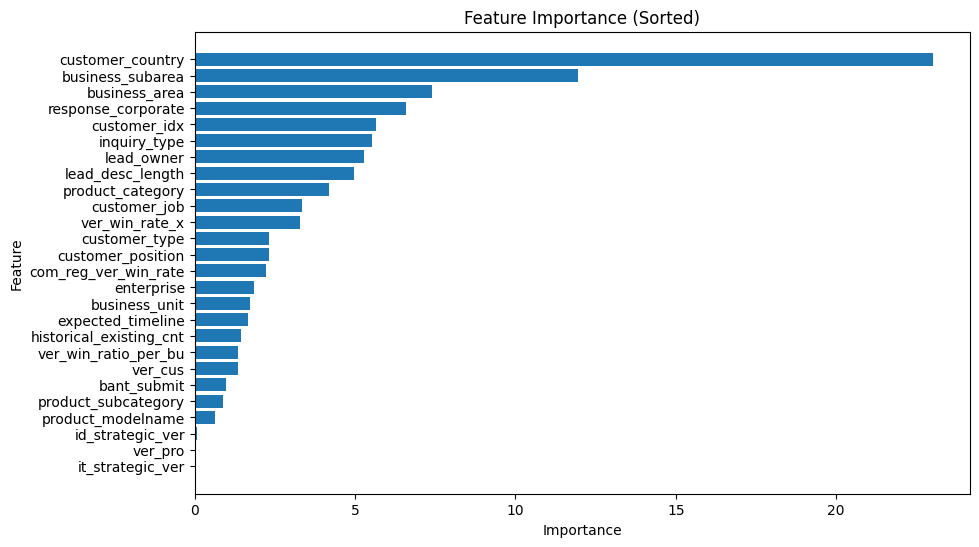

In [186]:
import matplotlib.pyplot as plt

feature_importance = model.feature_importances_
# 중요도가 큰 순서대로 정렬된 인덱스
sorted_idx = np.argsort(feature_importance)

# 특성 이름을 해당 순서대로 정렬
sorted_features = x_train.columns[sorted_idx]

# 정렬된 중요도
sorted_importance = feature_importance[sorted_idx]

# 특성 중요도를 가로 막대 그래프로 표현
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
plt.yticks(range(len(sorted_importance)), sorted_features)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Sorted)')
plt.show()

### 모델 학습

In [187]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
print("Cross Validation 평균 정확도:", scores.mean())

Learning rate set to 0.04867
0:	learn: 0.6436138	total: 71.9ms	remaining: 1m 11s
1:	learn: 0.5825318	total: 127ms	remaining: 1m 3s
2:	learn: 0.5401591	total: 183ms	remaining: 1m
3:	learn: 0.5034355	total: 230ms	remaining: 57.3s
4:	learn: 0.4755534	total: 267ms	remaining: 53.2s
5:	learn: 0.4408196	total: 316ms	remaining: 52.3s
6:	learn: 0.4209861	total: 355ms	remaining: 50.4s
7:	learn: 0.4003428	total: 389ms	remaining: 48.3s
8:	learn: 0.3835854	total: 424ms	remaining: 46.7s
9:	learn: 0.3677754	total: 458ms	remaining: 45.3s
10:	learn: 0.3539495	total: 493ms	remaining: 44.3s
11:	learn: 0.3417395	total: 532ms	remaining: 43.8s
12:	learn: 0.3282885	total: 574ms	remaining: 43.6s
13:	learn: 0.3150980	total: 615ms	remaining: 43.3s
14:	learn: 0.3025930	total: 663ms	remaining: 43.5s
15:	learn: 0.2936396	total: 703ms	remaining: 43.2s
16:	learn: 0.2796507	total: 752ms	remaining: 43.5s
17:	learn: 0.2684951	total: 790ms	remaining: 43.1s
18:	learn: 0.2634020	total: 838ms	remaining: 43.3s
19:	learn: 0.

### 모델 성능 보기

In [188]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [189]:
pred = model.predict(x_val)
get_clf_eval(y_val, pred)

오차행렬:
 [[  891    67]
 [  380 10522]]

정확도: 0.9623
정밀도: 0.7010
재현율: 0.9301
F1: 0.7995


## 4. 제출하기

### 테스트 데이터 예측

In [190]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [191]:
test_pred = model.predict(x_test)
sum(test_pred) # True로 예측된 개수

1574

### 제출 파일 작성

In [192]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**